In [1]:
import numpy as np
import pandas as pd
import math
%matplotlib inline
import pandas_datareader
import datetime
import pandas_datareader.data as web
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM 
import matplotlib.pyplot as plt 
plt.style.use('fivethirtyeight')

In [2]:
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2021, 4, 21)
tesla_df = web.DataReader("TSLA", 'yahoo', start, end)

In [3]:
tesla_df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,5.900,5.530,5.788,5.616,4640500.0,5.616
2012-01-04,5.734,5.500,5.642,5.542,3150500.0,5.542
2012-01-05,5.586,5.370,5.552,5.424,5027500.0,5.424
2012-01-06,5.558,5.282,5.440,5.382,4931500.0,5.382
2012-01-09,5.498,5.224,5.400,5.450,4485000.0,5.450


Text(0, 0.5, 'Close Price USD ($)')

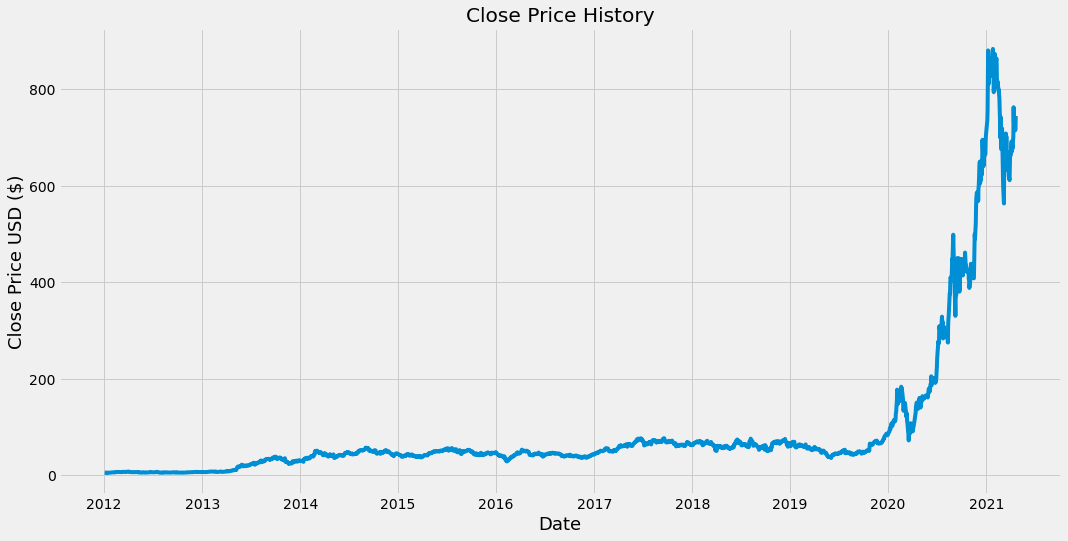

In [4]:
## Visualise the closing price history 
plt.figure(figsize=(16,8)) 
plt.title('Close Price History') 
plt.plot(tesla_df['Close']) 
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)

In [5]:
data = tesla_df.filter(['Close'])

dataset = data.values 

training_data_len = math.ceil(len(dataset) * 0.8)

training_data_len

1872

In [6]:
## Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.00120428],
       [0.00112005],
       [0.00098573],
       ...,
       [0.80824829],
       [0.81321109],
       [0.84181563]])

In [7]:
## Create the training data set 
train_data = scaled_data[0:training_data_len, :]
x_train = []
y_train = []

for i in range(90, len(train_data)):
    x_train.append(train_data[i-90:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 90:
        print(x_train)
        print(y_train)
        print()

[array([0.00120428, 0.00112005, 0.00098573, 0.00093793, 0.00101533,
       0.00109956, 0.00123843, 0.00124298, 0.        , 0.00086736,
       0.00091516, 0.00090378, 0.00086736, 0.00090606, 0.00105403,
       0.00117924, 0.00140006, 0.00148885, 0.00154348, 0.00142966,
       0.00154576, 0.00169829, 0.00190317, 0.00205115, 0.00200562,
       0.00208074, 0.00222872, 0.00189179, 0.00198058, 0.00236303,
       0.00246092, 0.00259296, 0.00277281, 0.00266581, 0.00260207,
       0.00267264, 0.00249507, 0.00246548, 0.00250873, 0.00241767,
       0.00264532, 0.00256109, 0.00249962, 0.00234937, 0.00235165,
       0.00234027, 0.00272045, 0.00300957, 0.00302778, 0.00284566,
       0.00277964, 0.00285249, 0.00277508, 0.00277053, 0.00281378,
       0.00264305, 0.0025702 , 0.003326  , 0.00344893, 0.00342845,
       0.00331007, 0.00328958, 0.00313933, 0.00346487, 0.00277964,
       0.00266126, 0.00235848, 0.0022014 , 0.00234482, 0.0024245 ,
       0.00245865, 0.00215359, 0.00215132, 0.00224693, 0.0023

In [8]:
x_train, y_train = np.array(x_train), np.array(y_train)

In [9]:
## Reshape the data
x_train.shape 

(1782, 90)

In [10]:
## Reshape the data into a 3D array
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1782, 90, 1)

In [11]:
## Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
## Compile the model 
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
## Train the model 
model.fit(x_train, y_train, batch_size=1, epochs=1)

1782/1782 [==============================] - 38s 19ms/step - loss: 6.9990e-05


In [14]:
## Create the testing data set 
test_data = scaled_data[training_data_len - 90: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(90, len(test_data)):
    x_test.append(test_data[i-90:i, 0])

In [15]:
x_test = np.array(x_test)

In [16]:
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [17]:
## Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
## Get the root mean squared error (RMSE)
rmse = np.sqrt( np.mean(predictions - y_test)**2)
rmse

12.904919273832924

<ipython-input-19-cc2bb1827526>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


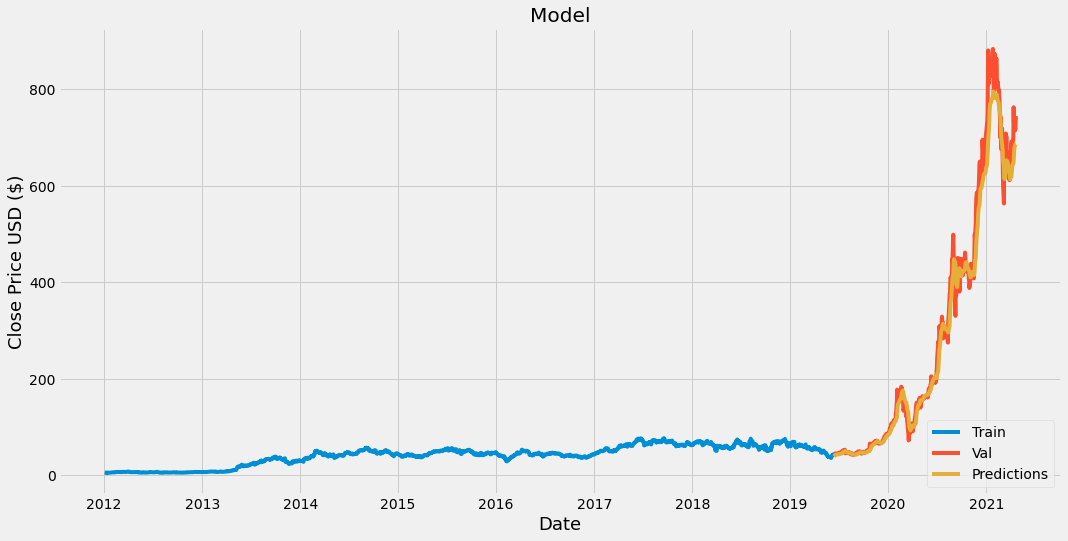

In [19]:
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions 
## Visualise the data 
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [20]:
## Show the actual price and predicted prices 
valid

,Close,Predictions
Date,,
2019-06-13,42.782001,39.737427
2019-06-14,42.984001,40.232803
2019-06-17,45.006001,40.657150
2019-06-18,44.948002,41.254665
2019-06-19,45.285999,41.851837
...,...,...
2021-04-15,738.849976,670.739624
2021-04-16,739.780029,678.805664
2021-04-19,714.630005,685.236328
